In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

import json

In [ ]:
# args
model_names = ["gpt-4o-mini", "Qwen2.5-7B-Instruct", "Llama-3.1-8B-Instruct"]
dataset_names = ["gsm8k", "medqa_us", "triviaqa"]
results_dir = "results"
calibrated_file = "results_calibrate_True.json"
non_calibrated_file = "results_calibrate_False.json"

In [ ]:
def acc_output(path: str):
    with open(path, "r") as f:
        data = json.load(f)
    print(np.mean(data["acc"]))

In [ ]:
# trivia_qa
dataset_name = "triviaqa"
model_name = ["Llama-3.1-8B-Instruct", "Qwen2.5-7B-Instruct"]
for model in model_name:

    p = f"{dataset_name}/{model}/results.json"
    print(f"======================")
    print(f"Model: {model}")
    acc_output(p)

Model: Llama-3.1-8B-Instruct
0.8091473743647657
Model: Qwen2.5-7B-Instruct
0.660631143300569


## Generate Latex Table

In [ ]:
df = pd.read_csv(f"{results_dir}/summary.csv")


def arrow(delta: float) -> str:
    """根据差值返回上下箭头及绝对值"""
    sym = r"\uparrow" if delta > 0 else r"\downarrow"
    return f"{sym}{abs(delta):.2f}"


lines = [
    r"\begin{table}[htbp]",
    r"    \centering",
    r"    \bicaption{使用不同方法计算模型输出内容的置信度指标在各数据集上的 AUROC（\%）得分}"
    r"{AUROC (\%) scores for confidence metrics computed using different methods across datasets}",
    r"    \label{tab:auroc}",
    r"    \begin{tabular}{llll}",
    r"    \toprule",
    r"        - & \textbf{GSM8K(\%)} & \textbf{MedQA\_US(\%)} & \textbf{TriviaQA(\%)} \\",
    r"    \midrule",
]

for model in model_names:
    # 模型名
    lines.append(f"        % {model}")
    lines.append(r"        \rowcolor{gray!20}")
    lines.append(f"        \\multicolumn{{4}}{{c}}{{\\textbf{{{model}}}}} \\\\")
    # 正确率行 (acc)
    accs = []
    for ds in dataset_names:
        val = df.query("model_name==@model and dataset_name==@ds")["acc"].mean()
        accs.append(f"{val*100:.2f}")  # 如果 acc 已经是百分比则去掉 *100
    lines.append(r"        \rowcolor{gray!20} 正确率 & " + " & ".join(accs) + r" \\")
    # 本研究方法行 (auroc where enable_calibrate=True)
    ours_cells = []
    directs = []
    for ds in dataset_names:
        ours = df.query(
            "model_name==@model and dataset_name==@ds and enable_calibrate==True"
        )["auroc"].mean()
        direct = df.query(
            "model_name==@model and dataset_name==@ds and enable_calibrate==False"
        )["auroc"].mean()
        directs.append(direct)
        ours_cells.append(f"{ours*100:.2f}\\scriptsize~({arrow((ours-direct)*100)})")
    lines.append("        本研究方法 & " + " & ".join(ours_cells) + r" \\")

    # 直接 prompt 输出行
    direct_cells = [f"{d*100:.2f}" for d in directs]
    lines.append("        直接 prompt 输出 & " + " & ".join(direct_cells) + r" \\")
    lines.append("")

lines += [
    r"    \bottomrule",
    r"    \end{tabular}",
    r"\end{table}",
]

# 打印最终 LaTeX 表格
print("\n".join(lines))

\begin{table}[htbp]
    \centering
    \bicaption{使用不同方法计算模型输出内容的置信度指标在各数据集上的 AUROC（\%）得分}{AUROC (\%) scores for confidence metrics computed using different methods across datasets}
    \label{tab:auroc}
    \begin{tabular}{llll}
    \toprule
        - & \textbf{GSM8K(\%)} & \textbf{MedQA\_US(\%)} & \textbf{TriviaQA(\%)} \\
    \midrule
        % gpt-4o-mini
        \rowcolor{gray!20}
        \multicolumn{4}{c}{\textbf{gpt-4o-mini}} \\
        \rowcolor{gray!20} 正确率 & 90.52 & 79.50 & 79.36 \\
        本研究方法 & 55.68\scriptsize~(\downarrow8.25) & 75.58\scriptsize~(\downarrow0.12) & 65.08\scriptsize~(\downarrow0.74) \\
        直接 prompt 输出 & 63.94 & 75.70 & 65.81 \\

        % Qwen2.5-7B-Instruct
        \rowcolor{gray!20}
        \multicolumn{4}{c}{\textbf{Qwen2.5-7B-Instruct}} \\
        \rowcolor{gray!20} 正确率 & 91.88 & 60.08 & 58.90 \\
        本研究方法 & 55.68\scriptsize~(\uparrow8.27) & 59.95\scriptsize~(\uparrow8.36) & 61.26\scriptsize~(\uparrow10.01) \\
        直接 prompt 输出 & 47.41 & 51

## CDF

In [ ]:
LINE_STYLES = {
    "Uncalibrated": {"color": "#E64B35", "linestyle": "-", "lw": 2},
    "Calibrated": {"color": "#357EBD", "linestyle": "--", "lw": 2},
}


def plot_cdf(ax, model_name, dataset_name):
    # 1. read data
    with open(f"{results_dir}/{model_name}/{dataset_name}/{calibrated_file}", "r") as f:
        data = json.load(f)["data"]  # 校准后数据
        cal = [min(x["confidence"], 100) for x in data]
    with open(
        f"{results_dir}/{model_name}/{dataset_name}/{non_calibrated_file}", "r"
    ) as f:
        data = json.load(f)["data"]  # 未校准数据
        noc = [min(x["confidence"], 100) for x in data]

    # 2. data preprocess
    cal_sorted = np.sort(cal)
    noc_sorted = np.sort(noc)

    # 3. generate cumulative probability axis (0-1)
    cal_cumprob = np.linspace(0, 1, len(cal_sorted))
    noc_cumprob = np.linspace(0, 1, len(noc_sorted))

    ax.plot(noc_sorted, noc_cumprob, **LINE_STYLES["Uncalibrated"])
    ax.plot(cal_sorted, cal_cumprob, **LINE_STYLES["Calibrated"])

    ax.set_xlabel("Confidence Score", fontsize=12)
    ax.set_ylabel("Cumulative Probability", fontsize=12)
    # ax.set_title(f"CDF of Confidence Scores ({model_name}, {dataset_name})", fontsize=14)
    ax.grid(True, alpha=0.3)

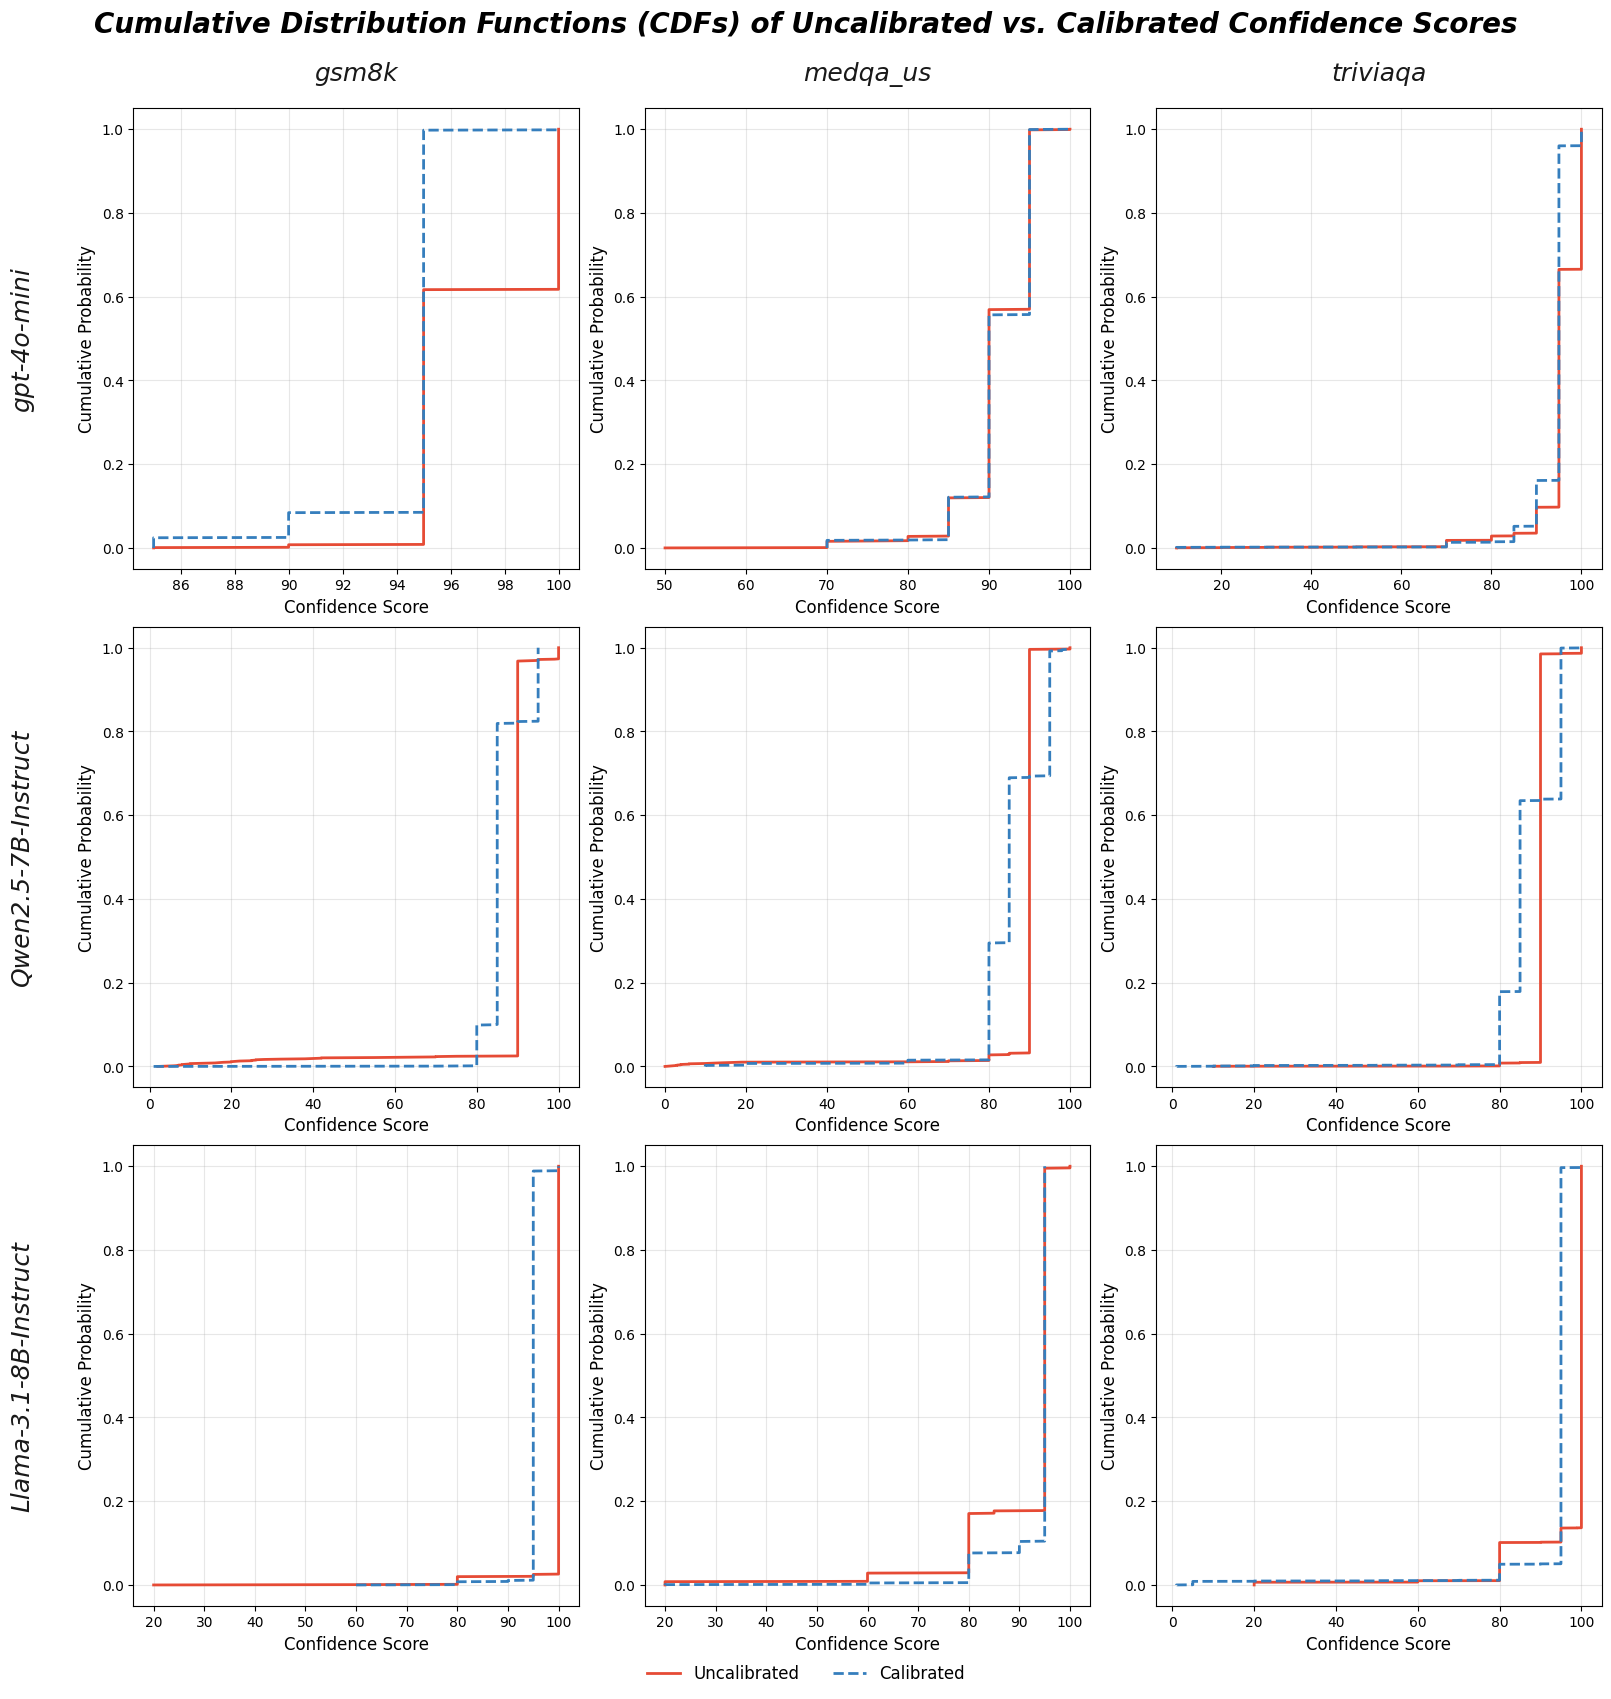

In [ ]:
fig, axes = plt.subplots(
    len(model_names),
    len(dataset_names),
    layout="constrained",
    figsize=(16, 16),
    squeeze=False,
)
for i, model_name in enumerate(model_names):
    for j, dataset in enumerate(dataset_names):
        plot_cdf(axes[i, j], model_name, dataset)

for i, model_name in enumerate(model_names):
    axes[i, 0].text(
        x=-0.25,
        y=0.5,
        s=f"{model_name}",
        fontsize=18,
        rotation=90,
        transform=axes[i, 0].transAxes,
        va="center",
        ha="center",
        fontstyle="italic",
        alpha=0.9,
    )

for j, dataset in enumerate(dataset_names):
    axes[0, j].set_title(
        f"{dataset}", fontsize=18, pad=20, fontstyle="italic", alpha=0.9
    )

fig.legend(
    handles=[
        plt.Line2D([], [], **LINE_STYLES["Uncalibrated"]),
        plt.Line2D([], [], **LINE_STYLES["Calibrated"]),
    ],
    labels=["Uncalibrated", "Calibrated"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.025),  # 调整图例位置到主图上方
    ncol=2,
    fontsize=12,
    frameon=False,
)

fig.suptitle(
    "Cumulative Distribution Functions (CDFs) of Uncalibrated vs. Calibrated Confidence Scores",
    fontsize=20,
    fontweight="bold",
    fontstyle="italic",
    y=1.03,
)
fig.savefig("outputs/cdf.pdf", dpi=1000, bbox_inches="tight", pad_inches=0.5)

fig.show()

## AUROC bar plot

In [ ]:
data = pd.read_csv(f"{results_dir}/summary.csv")
data

,dataset_name,model_name,enable_calibrate,acc,auroc,valid_rate
0,gsm8k,Qwen2.5-7B-Instruct,True,0.917236,0.556815,0.998484
1,gsm8k,Qwen2.5-7B-Instruct,False,0.920394,0.474068,1.000000
2,medqa_us,Qwen2.5-7B-Instruct,True,0.596229,0.599491,1.000000
3,medqa_us,Qwen2.5-7B-Instruct,False,0.605346,0.515861,0.999214
4,triviaqa,Qwen2.5-7B-Instruct,True,0.588378,0.612567,0.992126
5,triviaqa,Qwen2.5-7B-Instruct,False,0.589600,0.512446,0.998568
6,gsm8k,Llama-3.1-8B-Instruct,True,0.880518,0.510760,0.996209
7,gsm8k,Llama-3.1-8B-Instruct,False,0.872616,0.570966,0.993935
8,medqa_us,Llama-3.1-8B-Instruct,True,0.670597,0.550445,0.999214
9,medqa_us,Llama-3.1-8B-Instruct,False,0.672427,0.611035,1.000000


   dataset_name   model_name  enable_calibrate       acc     auroc  valid_rate
12        gsm8k  gpt-4o-mini              True  0.904473  0.556823    1.000000
13        gsm8k  gpt-4o-mini             False  0.905989  0.639351    1.000000
14     triviaqa  gpt-4o-mini              True  0.793207  0.650750    1.000000
15     triviaqa  gpt-4o-mini             False  0.794010  0.658143    0.999479
16     medqa_us  gpt-4o-mini              True  0.790259  0.755825    1.000000
17     medqa_us  gpt-4o-mini             False  0.799686  0.756978    1.000000
  dataset_name           model_name  enable_calibrate       acc     auroc  \
0        gsm8k  Qwen2.5-7B-Instruct              True  0.917236  0.556815   
1        gsm8k  Qwen2.5-7B-Instruct             False  0.920394  0.474068   
2     medqa_us  Qwen2.5-7B-Instruct              True  0.596229  0.599491   
3     medqa_us  Qwen2.5-7B-Instruct             False  0.605346  0.515861   
4     triviaqa  Qwen2.5-7B-Instruct              True  0.58837

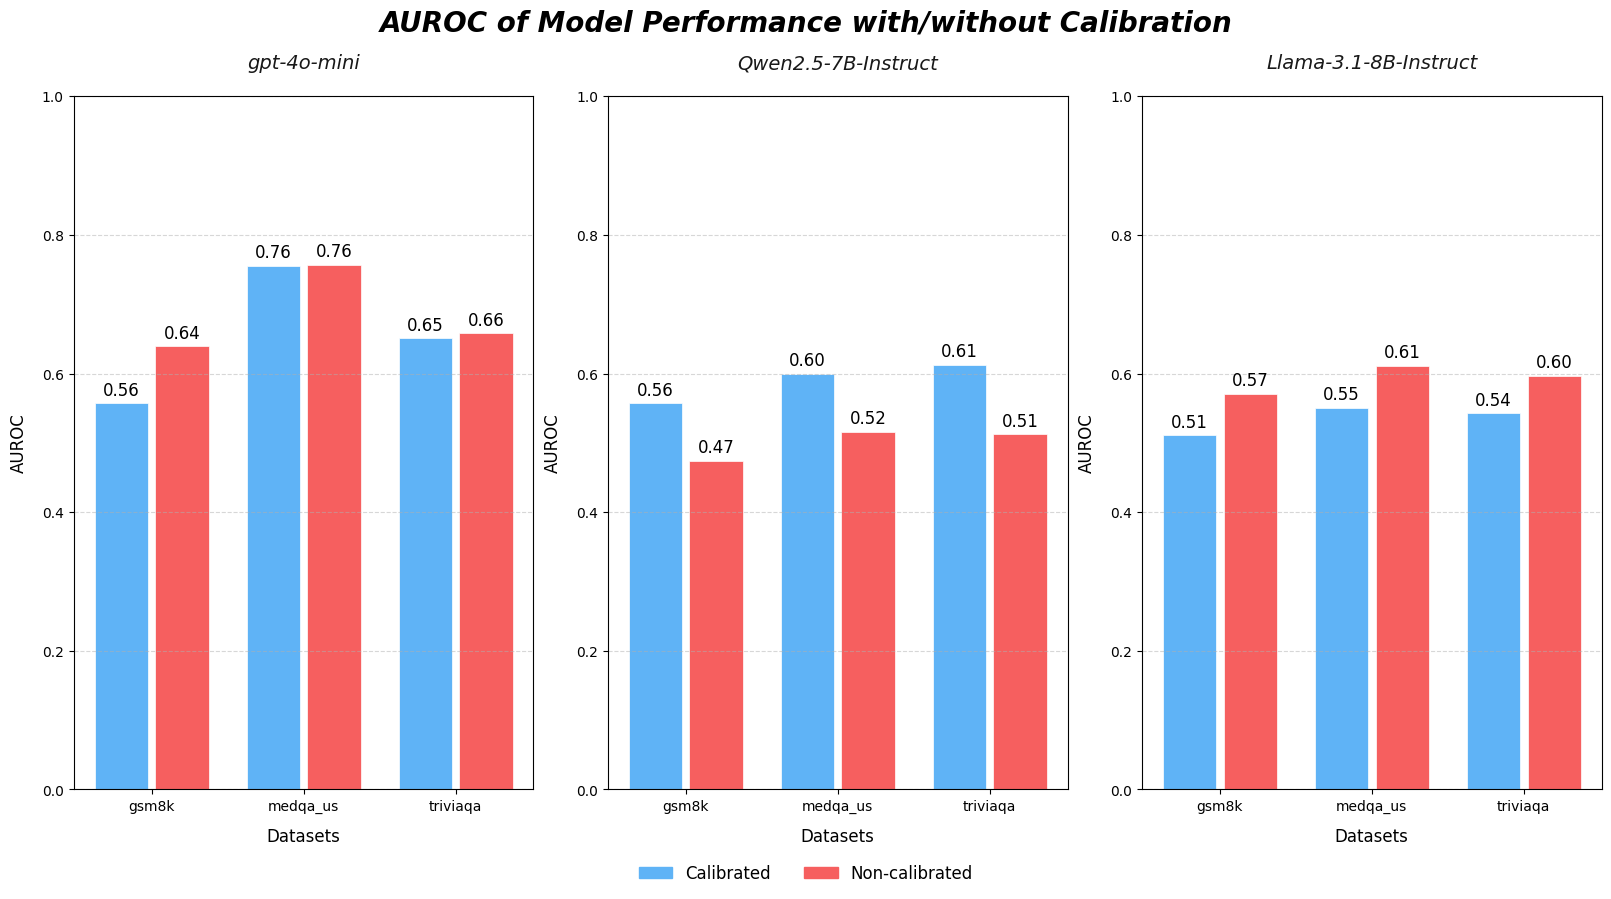

In [ ]:
bar_width = 0.35
bar_gap = 0.05

CAL_COLOR = "#5fb3f6"
UNCAL_COLOR = "#f65f5f"


def plot_bar_plot(ax, model_name: str, dataset_names: List[str]):
    # 1. read data
    data = pd.read_csv(f"{results_dir}/summary.csv")
    data = data.query(
        f"model_name == '{model_name}' and dataset_name in {dataset_names}"
    )
    print(data)

    cals = data.query("enable_calibrate == True")
    cals_auroc = [
        cals.query(f"dataset_name == '{dataset_name}'")["auroc"].values[0]
        for dataset_name in dataset_names
    ]
    non_cals = data.query("enable_calibrate == False")
    non_cals_auroc = [
        non_cals.query(f"dataset_name == '{dataset_name}'")["auroc"].values[0]
        for dataset_name in dataset_names
    ]
    # 2. plot
    x = np.arange(len(dataset_names)) + 1
    cals_bar = ax.bar(
        x - (bar_width + bar_gap) / 2,
        height=cals_auroc,
        width=bar_width,
        # label="Calibrated",
        color=CAL_COLOR,
        edgecolor="white",
        linewidth=0.5,
    )
    non_cals_bar = ax.bar(
        x + (bar_width + bar_gap) / 2,
        height=non_cals_auroc,
        width=bar_width,
        # label="Non-calibrated",
        color=UNCAL_COLOR,
        edgecolor="white",
        linewidth=0.5,
    )
    ax.bar_label(cals_bar, padding=3, fontsize=12, fmt="%.2f")
    ax.bar_label(non_cals_bar, padding=3, fontsize=12, fmt="%.2f")

    ax.set_xticks(x)
    ax.set_xticklabels(dataset_names)
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUROC", fontsize=12, labelpad=10)
    ax.set_xlabel("Datasets", fontsize=12, labelpad=10)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_title(
        f"{model_name}",
        fontsize=14,
        pad=20,
        fontstyle="italic",
        alpha=0.9,
    )


fig, axes = plt.subplots(
    1,
    len(model_names),
    layout="constrained",
    figsize=(16, 8),
    squeeze=False,
)
for i, model_name in enumerate(model_names):
    plot_bar_plot(axes[0, i], model_name, dataset_names)

fig.suptitle(
    "AUROC of Model Performance with/without Calibration",
    fontsize=20,
    fontweight="bold",
    fontstyle="italic",
    y=1.05,
)
handles = [
    plt.Rectangle((0, 0), 1, 1, color=CAL_COLOR, label="Calibrated"),
    plt.Rectangle((0, 0), 1, 1, color=UNCAL_COLOR, label="Non-calibrated"),
]
fig.legend(
    handles=handles,
    labels=["Calibrated", "Non-calibrated"],  # 标签文本
    loc="lower center",
    bbox_to_anchor=(0.5, -0.06),
    ncol=2,
    fontsize=12,
    frameon=False,
)
fig.savefig("outputs/auroc_bar.pdf", dpi=1000, bbox_inches="tight", pad_inches=0.5)

plt.show()